# COVID-19 AUSTRIA STATISTICS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import urllib.request
url = 'https://raw.githubusercontent.com/covid19-eu-zh/covid19-eu-data/master/dataset/covid-19-at.csv'
filename = 'covid_data/covid-19-at.csv'
urllib.request.urlretrieve(url, filename)

('covid_data/covid-19-at.csv', <http.client.HTTPMessage at 0x23fdda77fd0>)

In [3]:
import csv
import datetime
from datetime import date

today = date.today()
today = today.strftime("%y-%m-%d")
print("Today's date:", today)

safe_date = date.today()-datetime.timedelta(2)
safe = safe_date.strftime("%y-%m-%d")
print("Safe date:", safe)

date_time_str = '2018-06-29T08:15:27'
date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%dT%H:%M:%S')

with open('covid_data/covid-19-at.csv', 'r') as i, open('covid_data/covid-19-austria.csv', 'w', newline='') as o:
    r = csv.reader(i, delimiter=',')
    writer = csv.writer(o)
    writer.writerow(["country", "name", "cases", "recovered", "deaths", "tests", "hospitalized", "intensive_care", "datetime"])
    #for row in r:
    #    if row[8] == "2020-05-09T15:00:00": 
    #        writer.writerow(row)
    #        print(row)
    max_value = date_time_obj
    #most recent date
    for row in r:
        if today in row[8]:
            date_time = row[8]
            date_time_object = datetime.datetime.strptime(date_time, '%Y-%m-%dT%H:%M:%S')
            if date_time_object > max_value: 
                max_value = date_time_object
    print("Most recent date: ", max_value)
    
                
                
                
with open('covid_data/covid-19-at.csv', 'r') as i, open('covid_data/covid-19-austria.csv', 'w', newline='') as o:
    r = csv.reader(i, delimiter=',')
    writer = csv.writer(o)
    writer.writerow(["country", "name", "cases", "recovered", "deaths", "tests", "hospitalized", "intensive_care", "datetime"])
                
    #create csv with most recent data           
    for row in r:
        if today in row[8]:
            date_time = row[8]
            date_time_object = datetime.datetime.strptime(date_time, '%Y-%m-%dT%H:%M:%S')
            if date_time_object == max_value: 
                writer.writerow(row)
                #print(row)    
        

pd.read_csv('covid_data/covid-19-austria.csv')    

Today's date: 20-06-03
Safe date: 20-06-01
Most recent date:  2020-06-03 09:30:00


,country,name,cases,recovered,deaths,tests,hospitalized,intensive_care,datetime
0,AT,Burgenland,342,328,11,13232,2,0,2020-06-03T09:30:00
1,AT,Kärnten,416,398,13,17836,0,0,2020-06-03T09:30:00
2,AT,Vorarlberg,900,867,19,21931,0,0,2020-06-03T09:30:00
3,AT,Salzburg,1220,1197,38,33675,0,0,2020-06-03T09:30:00
4,AT,Steiermark,1837,1655,148,52371,7,2,2020-06-03T09:30:00
5,AT,Oberösterreich,2297,2221,61,64275,3,0,2020-06-03T09:30:00
6,AT,Niederösterreich,2867,2687,100,73642,19,6,2020-06-03T09:30:00
7,AT,Wien,3260,2894,172,111587,49,11,2020-06-03T09:30:00
8,AT,Tirol,3535,3425,108,74409,7,2,2020-06-03T09:30:00
9,AT,NaN,16674,15672,670,462958,87,21,2020-06-03T09:30:00


## Selecting total values by time

In [4]:
with open('covid_data/covid-19-at.csv', 'r') as i, open('covid_data/covid-19-austria_time_total.csv', 'w', newline='') as o:
    r = csv.reader(i, delimiter=',')
    writer = csv.writer(o)
    writer.writerow(["country", "name", "cases", "recovered", "deaths", "tests", "hospitalized", "intensive_care", "datetime"])
                
    #create csv with most recent data           
    for row in r:
        #print(row)
        if row[1] == '':
            writer.writerow(row)
            #print(row)  
            
pd.read_csv('covid_data/covid-19-austria_time_total.csv') 

,country,name,cases,recovered,deaths,tests,hospitalized,intensive_care,datetime
0,AT,NaN,7269,NaN,NaN,NaN,702,110,2020-03-27T08:00:00
1,AT,NaN,7697,NaN,NaN,NaN,800,128,2020-03-27T09:30:00
2,AT,NaN,8346,NaN,NaN,NaN,744,135,2020-03-28T08:00:00
3,AT,NaN,9103,NaN,NaN,NaN,931,187,2020-03-29T09:30:00
4,AT,NaN,9772,NaN,NaN,NaN,999,193,2020-03-30T09:30:00
...,...,...,...,...,...,...,...,...,...
161,AT,NaN,16663,15596.0,668.0,451820.0,97,29,2020-06-02T08:00:00
162,AT,NaN,16663,15629.0,669.0,456378.0,88,26,2020-06-02T09:30:00
163,AT,NaN,16664,15629.0,669.0,456378.0,88,26,2020-06-02T15:00:00
164,AT,NaN,16674,15629.0,669.0,456378.0,88,26,2020-06-03T08:00:00


## Selecting Burgenland data by time

In [5]:
with open('covid_data/covid-19-at.csv', 'r') as i, open('covid_data/covid-19-austria_time_Burgenland.csv', 'w', newline='') as o:
    r = csv.reader(i, delimiter=',')
    writer = csv.writer(o)
    writer.writerow(["country", "name", "cases", "recovered", "deaths", "tests", "hospitalized", "intensive_care", "datetime"])
                
    #create csv with most recent data           
    for row in r:
        #print(row)
        if row[1] == 'Burgenland':
            writer.writerow(row)
            #print(row)  
            
pd.read_csv('covid_data/covid-19-austria_time_Burgenland.csv') 

,country,name,cases,recovered,deaths,tests,hospitalized,intensive_care,datetime
0,AT,Burgenland,4,NaN,NaN,NaN,NaN,NaN,2020-03-07T08:00:00
1,AT,Burgenland,4,NaN,NaN,NaN,NaN,NaN,2020-03-07T15:00:00
2,AT,Burgenland,4,NaN,NaN,NaN,NaN,NaN,2020-03-08T08:00:00
3,AT,Burgenland,4,NaN,NaN,NaN,NaN,NaN,2020-03-08T11:45:00
4,AT,Burgenland,4,NaN,NaN,NaN,NaN,NaN,2020-03-08T15:00:00
...,...,...,...,...,...,...,...,...,...
204,AT,Burgenland,342,326.0,11.0,13028.0,2.0,0.0,2020-06-02T08:00:00
205,AT,Burgenland,342,327.0,11.0,13089.0,2.0,0.0,2020-06-02T09:30:00
206,AT,Burgenland,342,327.0,11.0,13089.0,2.0,0.0,2020-06-02T15:00:00
207,AT,Burgenland,342,327.0,11.0,13089.0,2.0,0.0,2020-06-03T08:00:00


## Selecting Kärnten data by time

In [6]:
with open('covid_data/covid-19-at.csv', 'r') as i, open('covid_data/covid-19-austria_time_Kärnten.csv', 'w', newline='') as o:
    r = csv.reader(i, delimiter=',')
    writer = csv.writer(o)
    writer.writerow(["country", "name", "cases", "recovered", "deaths", "tests", "hospitalized", "intensive_care", "datetime"])
                
    #create csv with most recent data           
    for row in r:
        #print(row[1])
        if row[1] == "KÃ¤rnten":
            writer.writerow(row)
            #print(row)  
            
pd.read_csv('covid_data/covid-19-austria_time_Kärnten.csv')

,country,name,cases,recovered,deaths,tests,hospitalized,intensive_care,datetime
0,AT,Kärnten,1,NaN,NaN,NaN,NaN,NaN,2020-03-05T15:00:00
1,AT,Kärnten,1,NaN,NaN,NaN,NaN,NaN,2020-03-06T08:00:00
2,AT,Kärnten,1,NaN,NaN,NaN,NaN,NaN,2020-03-06T15:00:00
3,AT,Kärnten,1,NaN,NaN,NaN,NaN,NaN,2020-03-07T08:00:00
4,AT,Kärnten,1,NaN,NaN,NaN,NaN,NaN,2020-03-07T15:00:00
...,...,...,...,...,...,...,...,...,...
207,AT,Kärnten,415,398.0,13.0,17204.0,0.0,0.0,2020-06-02T08:00:00
208,AT,Kärnten,415,398.0,13.0,17395.0,0.0,0.0,2020-06-02T09:30:00
209,AT,Kärnten,415,398.0,13.0,17395.0,0.0,0.0,2020-06-02T15:00:00
210,AT,Kärnten,416,398.0,13.0,17395.0,0.0,0.0,2020-06-03T08:00:00


## Selecting Vorarlberg data by time

In [7]:
with open('covid_data/covid-19-at.csv', 'r') as i, open('covid_data/covid-19-austria_time_Vorarlberg.csv', 'w', newline='') as o:
    r = csv.reader(i, delimiter=',')
    writer = csv.writer(o)
    writer.writerow(["country", "name", "cases", "recovered", "deaths", "tests", "hospitalized", "intensive_care", "datetime"])
                
    #create csv with most recent data           
    for row in r:
        #print(row[1])
        if row[1] == "Vorarlberg":
            writer.writerow(row)
            #print(row)  
            
pd.read_csv('covid_data/covid-19-austria_time_Vorarlberg.csv')

,country,name,cases,recovered,deaths,tests,hospitalized,intensive_care,datetime
0,AT,Vorarlberg,1,NaN,NaN,NaN,NaN,NaN,2020-03-06T08:00:00
1,AT,Vorarlberg,1,NaN,NaN,NaN,NaN,NaN,2020-03-06T15:00:00
2,AT,Vorarlberg,1,NaN,NaN,NaN,NaN,NaN,2020-03-07T08:00:00
3,AT,Vorarlberg,1,NaN,NaN,NaN,NaN,NaN,2020-03-07T15:00:00
4,AT,Vorarlberg,1,NaN,NaN,NaN,NaN,NaN,2020-03-08T08:00:00
...,...,...,...,...,...,...,...,...,...
206,AT,Vorarlberg,899,866.0,19.0,21789.0,0.0,0.0,2020-06-02T08:00:00
207,AT,Vorarlberg,899,867.0,19.0,21789.0,0.0,0.0,2020-06-02T09:30:00
208,AT,Vorarlberg,899,867.0,19.0,21789.0,0.0,0.0,2020-06-02T15:00:00
209,AT,Vorarlberg,900,867.0,19.0,21789.0,0.0,0.0,2020-06-03T08:00:00


## Selecting Salzburg data by time

In [8]:
with open('covid_data/covid-19-at.csv', 'r') as i, open('covid_data/covid-19-austria_time_Salzburg.csv', 'w', newline='') as o:
    r = csv.reader(i, delimiter=',')
    writer = csv.writer(o)
    writer.writerow(["country", "name", "cases", "recovered", "deaths", "tests", "hospitalized", "intensive_care", "datetime"])
                
    #create csv with most recent data           
    for row in r:
        #print(row[1])
        if row[1] == "Salzburg":
            writer.writerow(row)
            #print(row)  
            
pd.read_csv('covid_data/covid-19-austria_time_Salzburg.csv')

,country,name,cases,recovered,deaths,tests,hospitalized,intensive_care,datetime
0,AT,Salzburg,3,NaN,NaN,NaN,NaN,NaN,2020-03-04T17:45:00
1,AT,Salzburg,3,NaN,NaN,NaN,NaN,NaN,2020-03-05T08:00:00
2,AT,Salzburg,4,NaN,NaN,NaN,NaN,NaN,2020-03-05T15:00:00
3,AT,Salzburg,4,NaN,NaN,NaN,NaN,NaN,2020-03-06T08:00:00
4,AT,Salzburg,5,NaN,NaN,NaN,NaN,NaN,2020-03-06T15:00:00
...,...,...,...,...,...,...,...,...,...
208,AT,Salzburg,1220,1197.0,38.0,33355.0,0.0,0.0,2020-06-02T08:00:00
209,AT,Salzburg,1220,1197.0,38.0,33485.0,0.0,0.0,2020-06-02T09:30:00
210,AT,Salzburg,1220,1197.0,38.0,33485.0,0.0,0.0,2020-06-02T15:00:00
211,AT,Salzburg,1220,1197.0,38.0,33485.0,0.0,0.0,2020-06-03T08:00:00


## Selecting Steiermark data by time

In [9]:
with open('covid_data/covid-19-at.csv', 'r') as i, open('covid_data/covid-19-austria_time_Steiermark.csv', 'w', newline='') as o:
    r = csv.reader(i, delimiter=',')
    writer = csv.writer(o)
    writer.writerow(["country", "name", "cases", "recovered", "deaths", "tests", "hospitalized", "intensive_care", "datetime"])
                
    #create csv with most recent data           
    for row in r:
        #print(row[1])
        if row[1] == "Steiermark":
            writer.writerow(row)
            #print(row)  
            
pd.read_csv('covid_data/covid-19-austria_time_Steiermark.csv')

,country,name,cases,recovered,deaths,tests,hospitalized,intensive_care,datetime
0,AT,Steiermark,4,NaN,NaN,NaN,NaN,NaN,2020-03-04T17:45:00
1,AT,Steiermark,4,NaN,NaN,NaN,NaN,NaN,2020-03-05T08:00:00
2,AT,Steiermark,4,NaN,NaN,NaN,NaN,NaN,2020-03-05T15:00:00
3,AT,Steiermark,4,NaN,NaN,NaN,NaN,NaN,2020-03-06T08:00:00
4,AT,Steiermark,5,NaN,NaN,NaN,NaN,NaN,2020-03-06T15:00:00
...,...,...,...,...,...,...,...,...,...
209,AT,Steiermark,1837,1646.0,147.0,51330.0,7.0,2.0,2020-06-02T08:00:00
210,AT,Steiermark,1837,1647.0,147.0,51705.0,7.0,2.0,2020-06-02T09:30:00
211,AT,Steiermark,1837,1647.0,147.0,51705.0,7.0,2.0,2020-06-02T15:00:00
212,AT,Steiermark,1837,1647.0,147.0,51705.0,7.0,2.0,2020-06-03T08:00:00


## Selecting Oberösterreich data by time

In [10]:
with open('covid_data/covid-19-at.csv', 'r') as i, open('covid_data/covid-19-austria_time_Oberösterreich.csv', 'w', newline='') as o:
    r = csv.reader(i, delimiter=',')
    writer = csv.writer(o)
    writer.writerow(["country", "name", "cases", "recovered", "deaths", "tests", "hospitalized", "intensive_care", "datetime"])
                
    #create csv with most recent data           
    for row in r:
        #print(row[1])
        if row[1] == "OberÃ¶sterreich":
            writer.writerow(row)
            #print(row)  
            
pd.read_csv('covid_data/covid-19-austria_time_Oberösterreich.csv')

,country,name,cases,recovered,deaths,tests,hospitalized,intensive_care,datetime
0,AT,Oberösterreich,1,NaN,NaN,NaN,NaN,NaN,2020-03-06T08:00:00
1,AT,Oberösterreich,1,NaN,NaN,NaN,NaN,NaN,2020-03-06T15:00:00
2,AT,Oberösterreich,4,NaN,NaN,NaN,NaN,NaN,2020-03-07T08:00:00
3,AT,Oberösterreich,4,NaN,NaN,NaN,NaN,NaN,2020-03-07T15:00:00
4,AT,Oberösterreich,7,NaN,NaN,NaN,NaN,NaN,2020-03-08T08:00:00
...,...,...,...,...,...,...,...,...,...
203,AT,Oberösterreich,2297,2215.0,60.0,63303.0,7.0,0.0,2020-06-02T08:00:00
204,AT,Oberösterreich,2297,2215.0,61.0,63575.0,3.0,0.0,2020-06-02T09:30:00
205,AT,Oberösterreich,2297,2215.0,61.0,63575.0,3.0,0.0,2020-06-02T15:00:00
206,AT,Oberösterreich,2297,2215.0,61.0,63575.0,3.0,0.0,2020-06-03T08:00:00


## Selecting Niederösterreich data by time

In [11]:
with open('covid_data/covid-19-at.csv', 'r') as i, open('covid_data/covid-19-austria_time_Niederösterreich.csv', 'w', newline='') as o:
    r = csv.reader(i, delimiter=',')
    writer = csv.writer(o)
    writer.writerow(["country", "name", "cases", "recovered", "deaths", "tests", "hospitalized", "intensive_care", "datetime"])
                
    #create csv with most recent data           
    for row in r:
        #print(row[1])
        if row[1] == "NiederÃ¶sterreich":
            writer.writerow(row)
            #print(row)  
            
pd.read_csv('covid_data/covid-19-austria_time_Niederösterreich.csv')

,country,name,cases,recovered,deaths,tests,hospitalized,intensive_care,datetime
0,AT,Niederösterreich,5,NaN,NaN,NaN,NaN,NaN,2020-03-04T17:45:00
1,AT,Niederösterreich,12,NaN,NaN,NaN,NaN,NaN,2020-03-05T08:00:00
2,AT,Niederösterreich,13,NaN,NaN,NaN,NaN,NaN,2020-03-05T15:00:00
3,AT,Niederösterreich,15,NaN,NaN,NaN,NaN,NaN,2020-03-06T08:00:00
4,AT,Niederösterreich,15,NaN,NaN,NaN,NaN,NaN,2020-03-06T15:00:00
...,...,...,...,...,...,...,...,...,...
209,AT,Niederösterreich,2866,2673.0,100.0,71433.0,21.0,10.0,2020-06-02T08:00:00
210,AT,Niederösterreich,2866,2678.0,100.0,72439.0,20.0,9.0,2020-06-02T09:30:00
211,AT,Niederösterreich,2866,2678.0,100.0,72439.0,20.0,9.0,2020-06-02T15:00:00
212,AT,Niederösterreich,2867,2678.0,100.0,72439.0,20.0,9.0,2020-06-03T08:00:00


## Selecting Wien data by time

In [12]:
with open('covid_data/covid-19-at.csv', 'r') as i, open('covid_data/covid-19-austria_time_Wien.csv', 'w', newline='') as o:
    r = csv.reader(i, delimiter=',')
    writer = csv.writer(o)
    writer.writerow(["country", "name", "cases", "recovered", "deaths", "tests", "hospitalized", "intensive_care", "datetime"])
                
    #create csv with most recent data           
    for row in r:
        #print(row[1])
        if row[1] == "Wien":
            writer.writerow(row)
            #print(row)  
            
pd.read_csv('covid_data/covid-19-austria_time_Wien.csv')

,country,name,cases,recovered,deaths,tests,hospitalized,intensive_care,datetime
0,AT,Wien,15,NaN,NaN,NaN,NaN,NaN,2020-03-04T17:45:00
1,AT,Wien,16,NaN,NaN,NaN,NaN,NaN,2020-03-05T08:00:00
2,AT,Wien,16,NaN,NaN,NaN,NaN,NaN,2020-03-05T15:00:00
3,AT,Wien,17,NaN,NaN,NaN,NaN,NaN,2020-03-06T08:00:00
4,AT,Wien,23,NaN,NaN,NaN,NaN,NaN,2020-03-06T15:00:00
...,...,...,...,...,...,...,...,...,...
209,AT,Wien,3249,2855.0,172.0,106863.0,53.0,14.0,2020-06-02T08:00:00
210,AT,Wien,3249,2879.0,172.0,108942.0,49.0,12.0,2020-06-02T09:30:00
211,AT,Wien,3253,2879.0,172.0,108942.0,49.0,12.0,2020-06-02T15:00:00
212,AT,Wien,3260,2879.0,172.0,108942.0,49.0,12.0,2020-06-03T08:00:00


## Selecting Tirol data by time

In [13]:
with open('covid_data/covid-19-at.csv', 'r') as i, open('covid_data/covid-19-austria_time_Tirol.csv', 'w', newline='') as o:
    r = csv.reader(i, delimiter=',')
    writer = csv.writer(o)
    writer.writerow(["country", "name", "cases", "recovered", "deaths", "tests", "hospitalized", "intensive_care", "datetime"])
                
    #create csv with most recent data           
    for row in r:
        #print(row[1])
        if row[1] == "Tirol":
            writer.writerow(row)
            #print(row)  
            
pd.read_csv('covid_data/covid-19-austria_time_Tirol.csv')

,country,name,cases,recovered,deaths,tests,hospitalized,intensive_care,datetime
0,AT,Tirol,2,NaN,NaN,NaN,NaN,NaN,2020-03-04T17:45:00
1,AT,Tirol,2,NaN,NaN,NaN,NaN,NaN,2020-03-05T08:00:00
2,AT,Tirol,3,NaN,NaN,NaN,NaN,NaN,2020-03-05T15:00:00
3,AT,Tirol,4,NaN,NaN,NaN,NaN,NaN,2020-03-06T08:00:00
4,AT,Tirol,4,NaN,NaN,NaN,NaN,NaN,2020-03-06T15:00:00
...,...,...,...,...,...,...,...,...,...
202,AT,Tirol,3538,3420.0,108.0,73515.0,7.0,3.0,2020-06-02T08:00:00
203,AT,Tirol,3538,3421.0,108.0,73959.0,7.0,3.0,2020-06-02T09:30:00
204,AT,Tirol,3535,3421.0,108.0,73959.0,7.0,3.0,2020-06-02T15:00:00
205,AT,Tirol,3535,3421.0,108.0,73959.0,7.0,3.0,2020-06-03T08:00:00


## Import global data

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Import Data
df_global = pd.read_csv("covid_data/covid-19-austria_time_total.csv")
print(df_global)
# Prepare Data

name_global = df_global['name'].tolist()
intensive_care_global = df_global['intensive_care'].tolist()
cases_global = df_global['cases'].tolist()
deaths_global = df_global['deaths'].tolist()
recovered_global = df_global['recovered'].tolist()
hospitalized_global = df_global['hospitalized'].tolist()
tests_global = df_global['tests'].tolist()
date_global = df_global['datetime'].tolist()

print(len(name_global))
print(len(intensive_care_global))
print(len(cases_global))
print(len(recovered_global))
print(len(hospitalized_global))
print(len(tests_global))
print(date_global)

    country  name  cases  recovered  deaths     tests  hospitalized  \
0        AT   NaN   7269        NaN     NaN       NaN           702   
1        AT   NaN   7697        NaN     NaN       NaN           800   
2        AT   NaN   8346        NaN     NaN       NaN           744   
3        AT   NaN   9103        NaN     NaN       NaN           931   
4        AT   NaN   9772        NaN     NaN       NaN           999   
..      ...   ...    ...        ...     ...       ...           ...   
161      AT   NaN  16663    15596.0   668.0  451820.0            97   
162      AT   NaN  16663    15629.0   669.0  456378.0            88   
163      AT   NaN  16664    15629.0   669.0  456378.0            88   
164      AT   NaN  16674    15629.0   669.0  456378.0            88   
165      AT   NaN  16674    15672.0   670.0  462958.0            87   

     intensive_care             datetime  
0               110  2020-03-27T08:00:00  
1               128  2020-03-27T09:30:00  
2               13

## Time overview graphs

In [15]:
pip install bokeh

Text(137.125, 0.5, 'Number of cases')

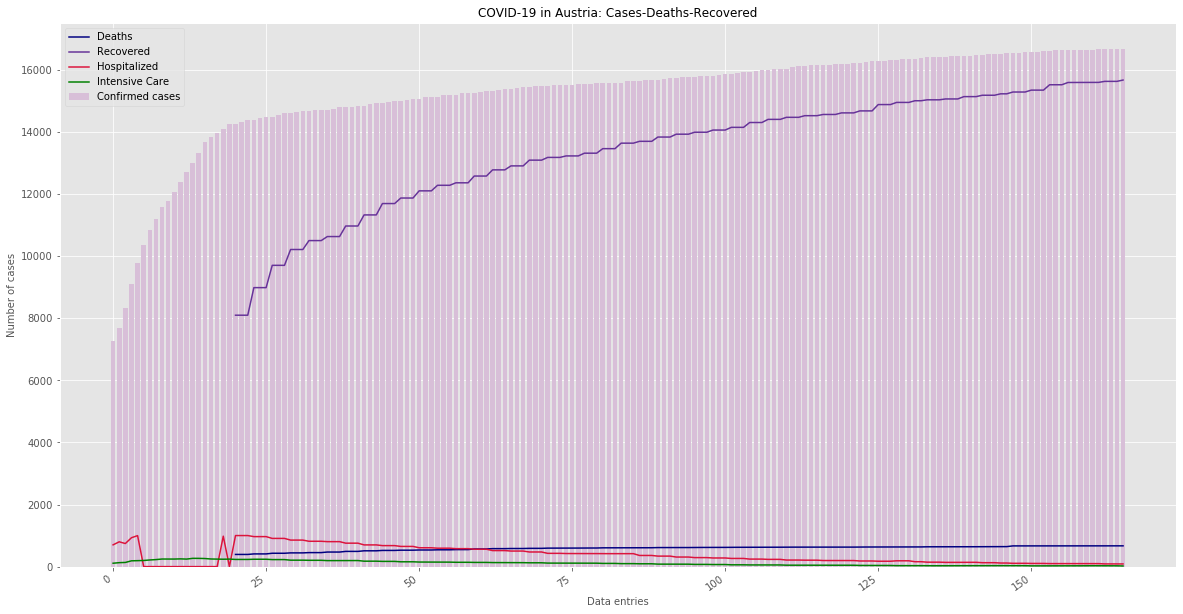

In [16]:
import bokeh
plt.style.use('ggplot')

bar_plot = cases_global
line_1 = deaths_global
labels = date_global
line_2 = recovered_global
line_3 = hospitalized_global
line_4 = intensive_care_global

fig, ax = plt.subplots(figsize=(20,10))

scale = 'linear'
fontsize = 10
y_pos = date_global

ax.set_xticklabels(labels, rotation=35, horizontalalignment= 'right', fontsize=10)

width = 0.75 # the width of the bars
plt.bar(y_pos, bar_plot, width, color='thistle', label='Confirmed cases')

ax.plot(y_pos,line_1,color='navy', label='Deaths')
ax.plot(y_pos,line_2,color='rebeccapurple', label='Recovered')
ax.plot(y_pos,line_3,color='crimson', label='Hospitalized')
ax.plot(y_pos,line_4,color='green', label='Intensive Care')

ax.legend(loc = 'upper left')     
ax.set_xscale(scale)
plt.savefig('images/time_global.png', dpi=400, format='png')
ax.set_title(f'COVID-19 in Austria: Cases-Deaths-Recovered', fontsize='large')
ax.set_xlabel(f'Data entries', fontsize='medium')
ax.set_ylabel(f'Number of cases', fontsize='medium')

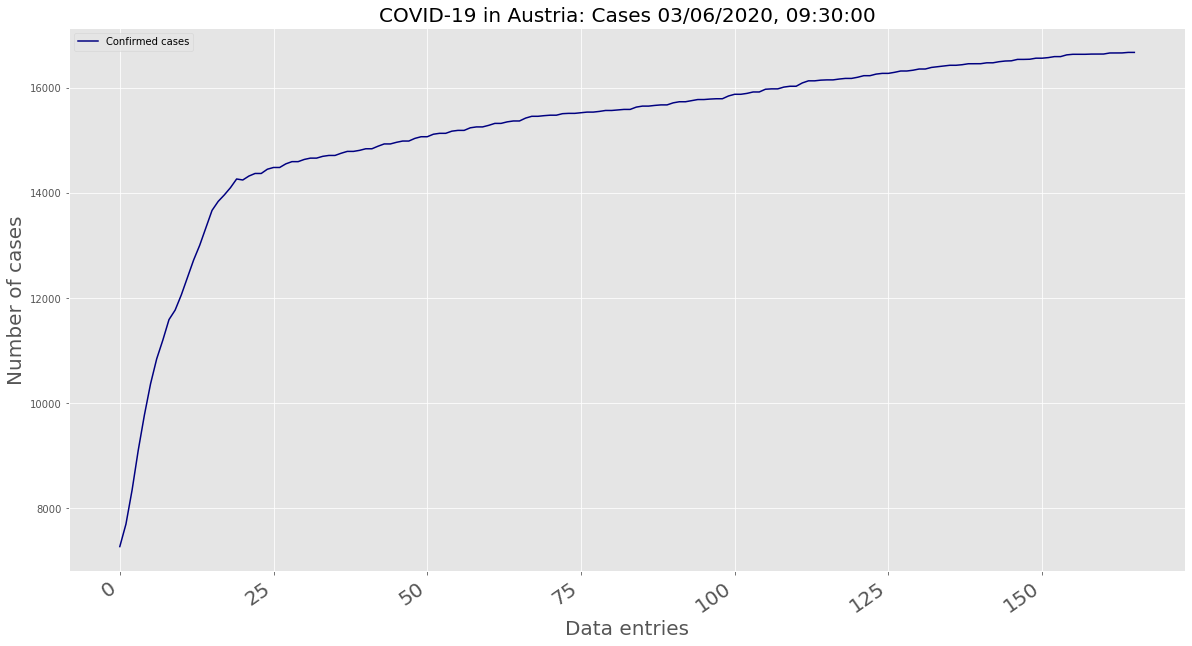

In [17]:
import bokeh
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(20,10))
line_1 = cases_global
scale = 'linear'
fontsize = 20
y_pos = date_global

ax.set_xticklabels(labels, rotation=35, horizontalalignment= 'right', fontsize=20)

ax.plot(y_pos,line_1,color='navy', label='Confirmed cases')

ax.legend(loc = 'upper left')     
ax.set_xscale(scale)

ax.set_title(f'COVID-19 in Austria: Cases '+max_value.strftime("%d/%m/%Y, %H:%M:%S"), fontsize=20)
ax.set_xlabel(f'Data entries', fontsize=20)
ax.set_ylabel(f'Number of cases', fontsize=20)

plt.savefig('images/time_cases.png', dpi=400, format='png')

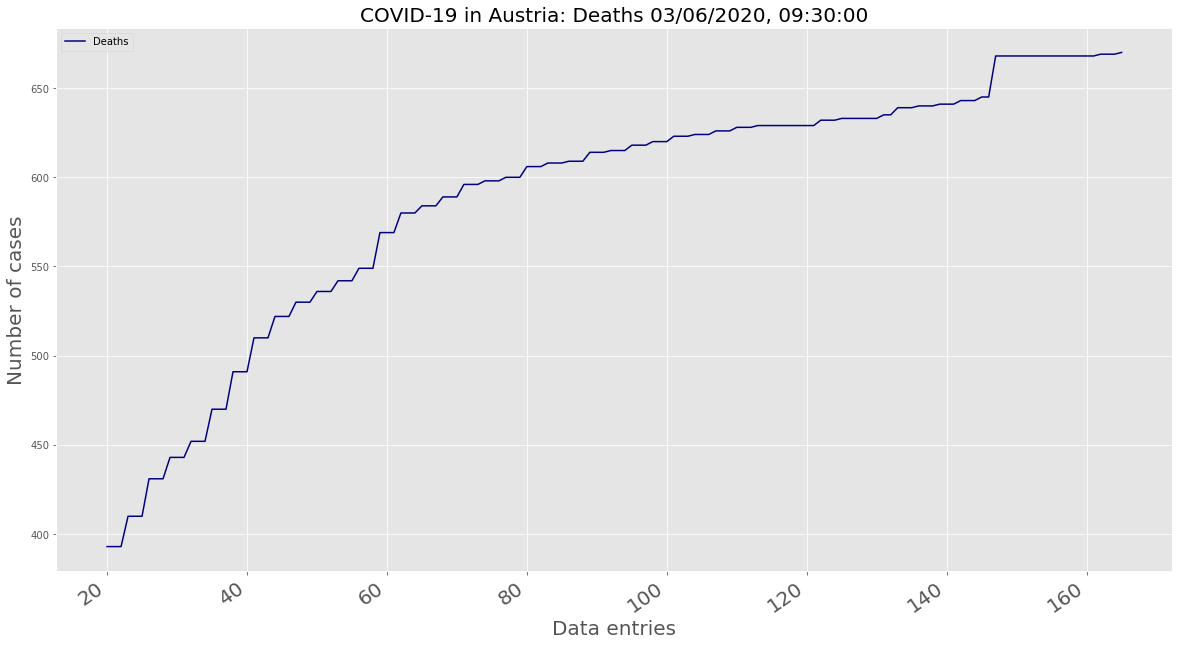

In [18]:
import bokeh
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(20,10))
line_1 = deaths_global
scale = 'linear'
fontsize = 20
y_pos = date_global

ax.set_xticklabels(labels, rotation=35, horizontalalignment= 'right', fontsize=20)

ax.plot(y_pos,line_1,color='navy', label='Deaths')

ax.legend(loc = 'upper left')     
ax.set_xscale(scale)

ax.set_title(f'COVID-19 in Austria: Deaths '+max_value.strftime("%d/%m/%Y, %H:%M:%S"), fontsize=20)
ax.set_xlabel(f'Data entries', fontsize=20)
ax.set_ylabel(f'Number of cases', fontsize=20)

plt.savefig('images/time_deaths.png', dpi=400, format='png')

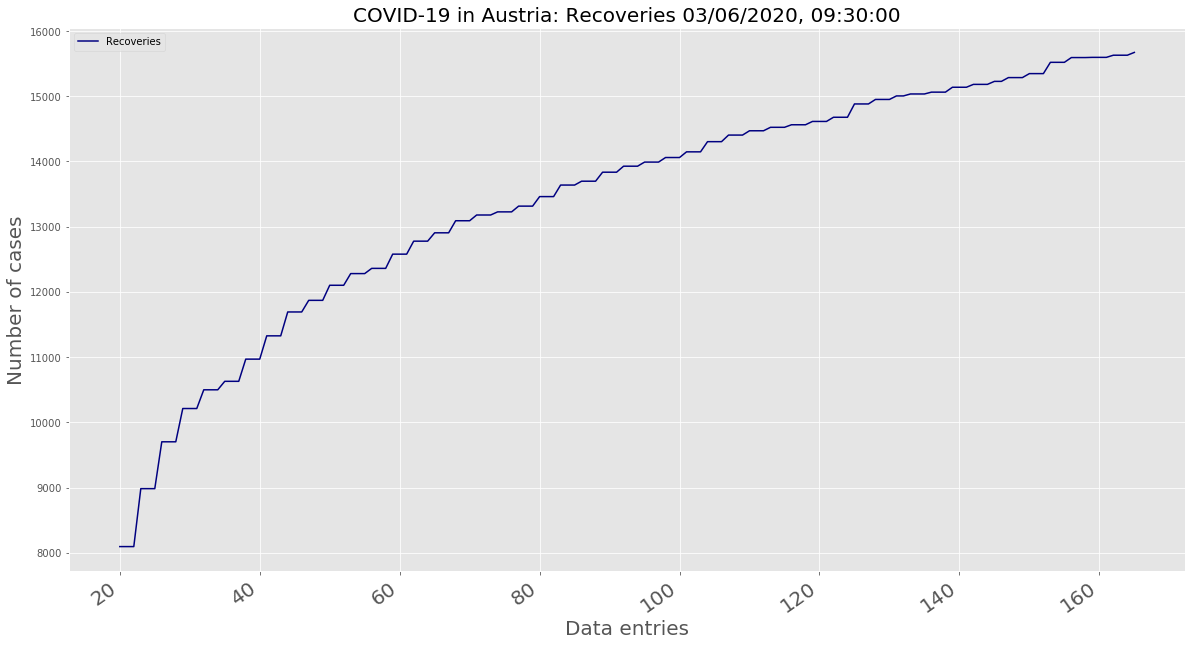

In [19]:
import bokeh
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(20,10))
line_1 = recovered_global
scale = 'linear'
fontsize = 20
y_pos = date_global

ax.set_xticklabels(labels, rotation=35, horizontalalignment= 'right', fontsize=20)

ax.plot(y_pos,line_1,color='navy', label='Recoveries')

ax.legend(loc = 'upper left')     
ax.set_xscale(scale)

ax.set_title(f'COVID-19 in Austria: Recoveries '+max_value.strftime("%d/%m/%Y, %H:%M:%S"), fontsize=20)
ax.set_xlabel(f'Data entries', fontsize=20)
ax.set_ylabel(f'Number of cases', fontsize=20)

plt.savefig('images/time_recovered.png', dpi=400, format='png')

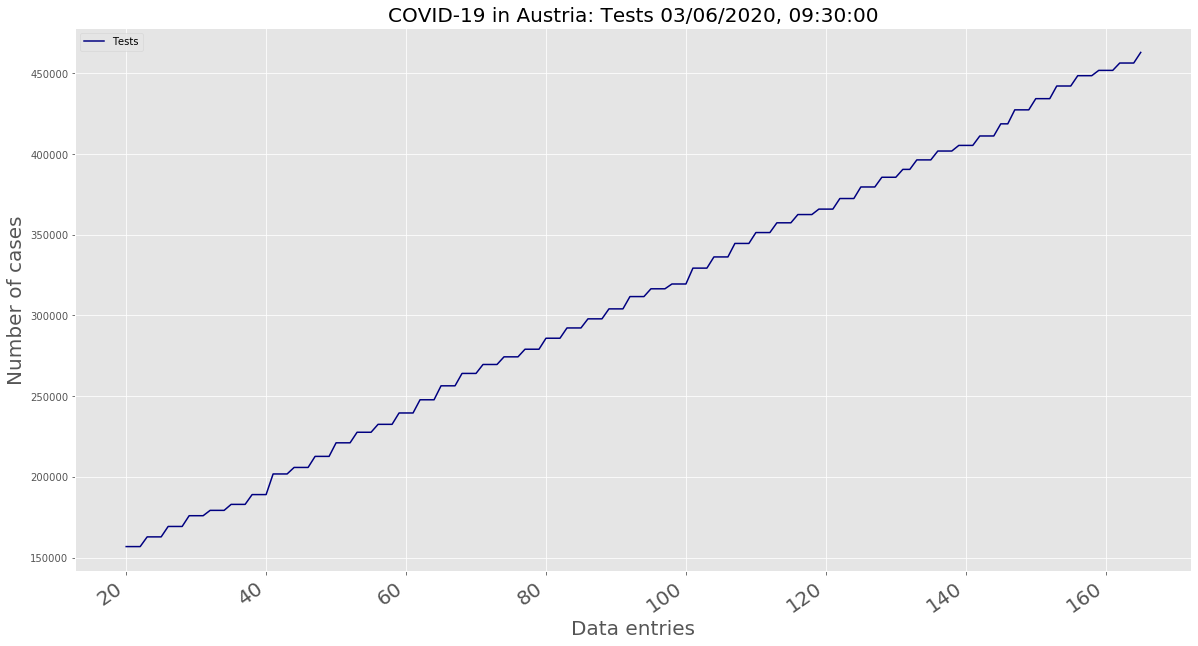

In [20]:
import bokeh
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(20,10))
line_1 = tests_global
scale = 'linear'
fontsize = 20
y_pos = date_global

ax.set_xticklabels(labels, rotation=35, horizontalalignment= 'right', fontsize=20)

ax.plot(y_pos,line_1,color='navy', label='Tests')

ax.legend(loc = 'upper left')     
ax.set_xscale(scale)

ax.set_title(f'COVID-19 in Austria: Tests '+max_value.strftime("%d/%m/%Y, %H:%M:%S"), fontsize=20)
ax.set_xlabel(f'Data entries', fontsize=20)
ax.set_ylabel(f'Number of cases', fontsize=20)

plt.savefig('images/time_tests.png', dpi=400, format='png')

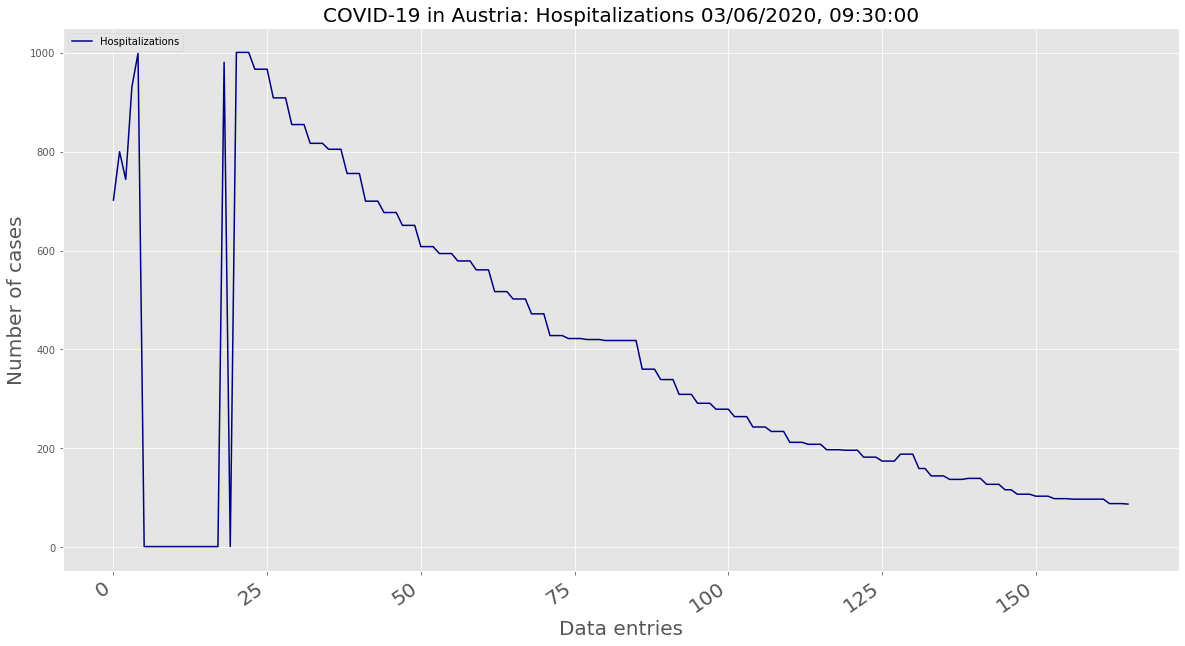

In [21]:
import bokeh
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(20,10))
line_1 = hospitalized_global
scale = 'linear'
fontsize = 10
y_pos = date_global

ax.set_xticklabels(labels, rotation=35, horizontalalignment= 'right', fontsize=20)

ax.plot(y_pos,line_1,color='navy', label='Hospitalizations')

ax.legend(loc = 'upper left')     
ax.set_xscale(scale)

ax.set_title(f'COVID-19 in Austria: Hospitalizations '+max_value.strftime("%d/%m/%Y, %H:%M:%S"), fontsize=20)
ax.set_xlabel(f'Data entries', fontsize=20)
ax.set_ylabel(f'Number of cases', fontsize=20)

plt.savefig('images/time_hospitalized.png', dpi=400, format='png')

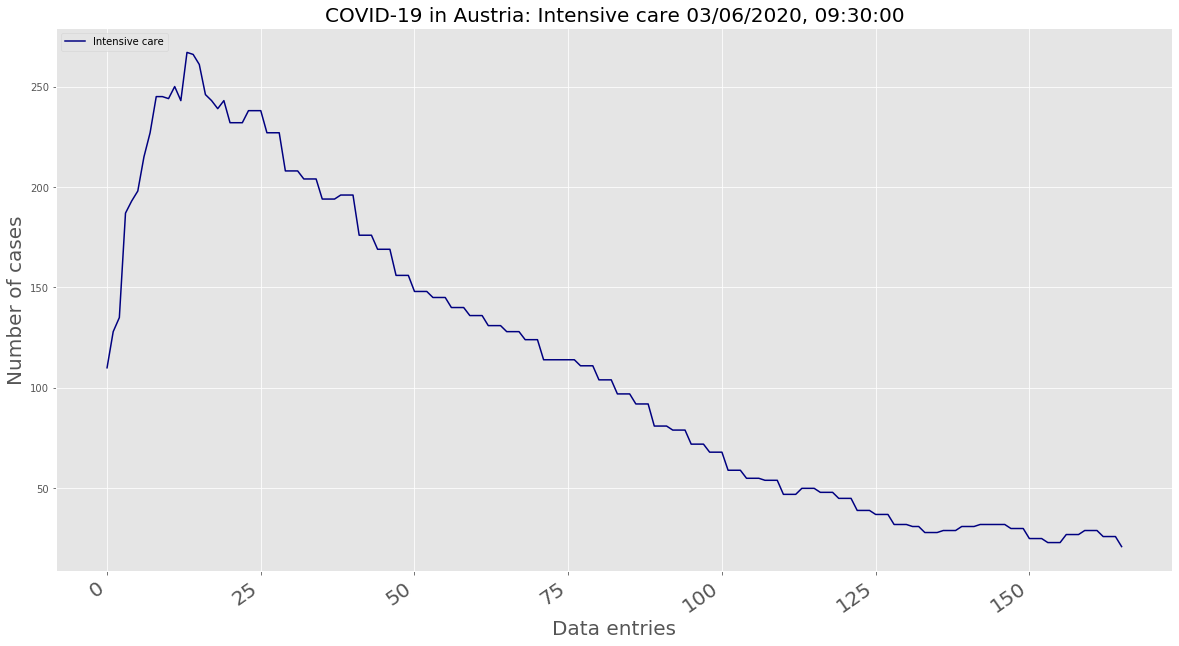

In [22]:
import bokeh
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(20,10))
line_1 = intensive_care_global
scale = 'linear'
fontsize = 20
y_pos = date_global

ax.set_xticklabels(labels, rotation=35, horizontalalignment= 'right', fontsize=20)

ax.plot(y_pos,line_1,color='navy', label='Intensive care')

ax.legend(loc = 'upper left')     
ax.set_xscale(scale)

ax.set_title(f'COVID-19 in Austria: Intensive care ' +max_value.strftime("%d/%m/%Y, %H:%M:%S"), fontsize=20)
ax.set_xlabel(f'Data entries', fontsize=20)
ax.set_ylabel(f'Number of cases', fontsize=20)

plt.savefig('images/time_intensive_care.png', dpi=400, format='png')

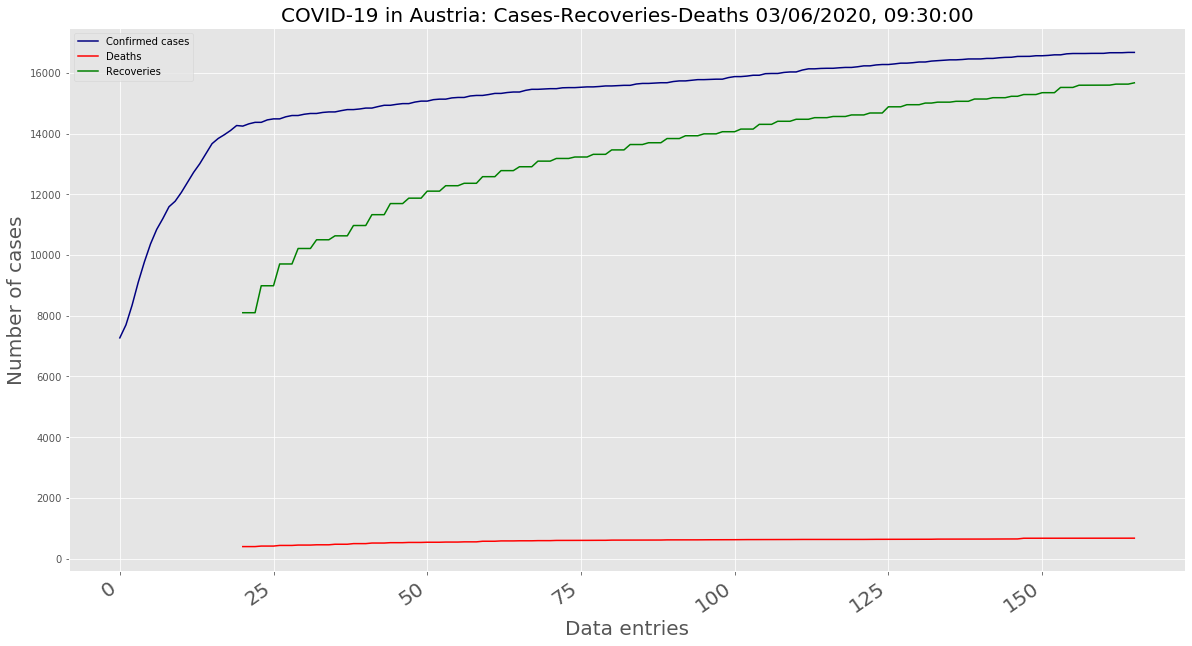

In [23]:
import bokeh
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(20,10))
line_1 = cases_global
line_2 = deaths_global
line_3 = recovered_global
scale = 'linear'
fontsize = 20
y_pos = date_global

ax.set_xticklabels(labels, rotation=35, horizontalalignment= 'right', fontsize=20)

ax.plot(y_pos,line_1,color='navy', label='Confirmed cases')
ax.plot(y_pos,line_2,color='red', label='Deaths')
ax.plot(y_pos,line_3,color='green', label='Recoveries')

ax.legend(loc = 'upper left')     
ax.set_xscale(scale)

ax.set_title(f'COVID-19 in Austria: Cases-Recoveries-Deaths '+max_value.strftime("%d/%m/%Y, %H:%M:%S"), fontsize=20)
ax.set_xlabel(f'Data entries', fontsize=20)
ax.set_ylabel(f'Number of cases', fontsize=20)

plt.savefig('images/time_cases_recovered_deaths.png', dpi=400, format='png')

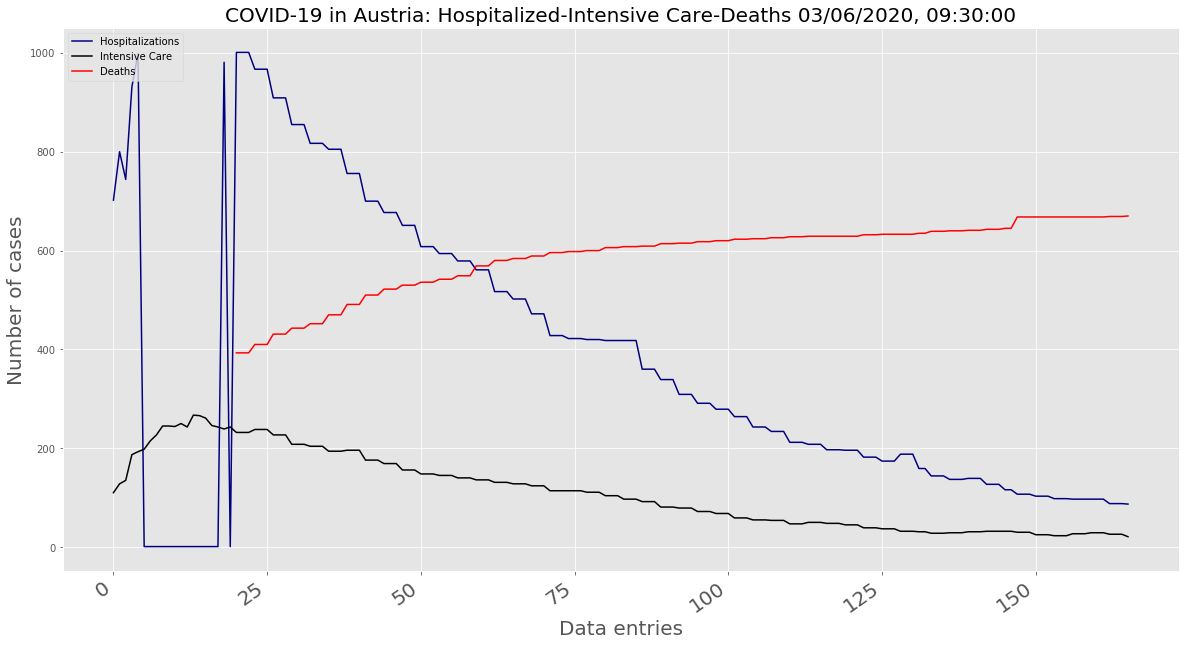

In [24]:
import bokeh
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(20,10))
line_1 = hospitalized_global
line_2 = intensive_care_global
line_3 = deaths_global
scale = 'linear'
fontsize = 20
y_pos = date_global

ax.set_xticklabels(labels, rotation=35, horizontalalignment= 'right', fontsize=20)

ax.plot(y_pos,line_1,color='navy', label='Hospitalizations')
ax.plot(y_pos,line_2,color='black', label='Intensive Care')
ax.plot(y_pos,line_3,color='red', label='Deaths')

ax.legend(loc = 'upper left')     
ax.set_xscale(scale)

ax.set_title(f'COVID-19 in Austria: Hospitalized-Intensive Care-Deaths '+max_value.strftime("%d/%m/%Y, %H:%M:%S"), fontsize=20)
ax.set_xlabel(f'Data entries', fontsize=20)
ax.set_ylabel(f'Number of cases', fontsize=20)

plt.savefig('images/time_hospitalized_intensive_care_deaths.png', dpi=400, format='png')

## Evolutions of Confirmed cases by state

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Import Data
df_b = pd.read_csv("covid_data/covid-19-austria_time_Burgenland.csv")
df_k = pd.read_csv("covid_data/covid-19-austria_time_Kärnten.csv")
df_v = pd.read_csv("covid_data/covid-19-austria_time_Vorarlberg.csv")
df_s = pd.read_csv("covid_data/covid-19-austria_time_Salzburg.csv")
df_st = pd.read_csv("covid_data/covid-19-austria_time_Steiermark.csv")
df_o = pd.read_csv("covid_data/covid-19-austria_time_Oberösterreich.csv")
df_n = pd.read_csv("covid_data/covid-19-austria_time_Niederösterreich.csv")
df_w = pd.read_csv("covid_data/covid-19-austria_time_Wien.csv")
df_t = pd.read_csv("covid_data/covid-19-austria_time_Tirol.csv")


# Prepare Data
name_b = df_b['name'].tolist()
intensive_care_b = df_b['intensive_care'].tolist()
cases_b = df_b['cases'].tolist()
deaths_b = df_b['deaths'].tolist()
recovered_b = df_b['recovered'].tolist()
hospitalized_b = df_b['hospitalized'].tolist()
tests_b = df_b['tests'].tolist()
date_b = df_b['datetime'].tolist()

cases_k = df_k['cases'].tolist()
date_k = df_k['datetime'].tolist()
deaths_k = df_k['deaths'].tolist()

cases_v = df_v['cases'].tolist()
date_v = df_v['datetime'].tolist()
deaths_v = df_v['deaths'].tolist()

cases_s = df_s['cases'].tolist()
date_s = df_s['datetime'].tolist()
deaths_s = df_s['deaths'].tolist()

cases_st = df_st['cases'].tolist()
date_st = df_st['datetime'].tolist()
deaths_st = df_st['deaths'].tolist()

cases_o = df_o['cases'].tolist()
date_o = df_o['datetime'].tolist()
deaths_o = df_o['deaths'].tolist()

cases_n = df_n['cases'].tolist()
date_n = df_n['datetime'].tolist()
deaths_n = df_n['deaths'].tolist()

cases_w = df_w['cases'].tolist()
date_w = df_w['datetime'].tolist()
deaths_w = df_w['deaths'].tolist()

cases_t = df_t['cases'].tolist()
date_t = df_t['datetime'].tolist()
deaths_t = df_t['deaths'].tolist()

list_entries = []


list_entries.append(len(cases_b))
list_entries.append(len(cases_k))
list_entries.append(len(cases_v))
list_entries.append(len(cases_s))
list_entries.append(len(cases_st))
list_entries.append(len(cases_o))
list_entries.append(len(cases_n))
list_entries.append(len(cases_w))
list_entries.append(len(cases_t))

list_entries = sorted(list_entries)

print(list_entries)

smallest_number = list_entries[0]

print(smallest_number)


[207, 208, 209, 211, 212, 213, 214, 214, 214]
207


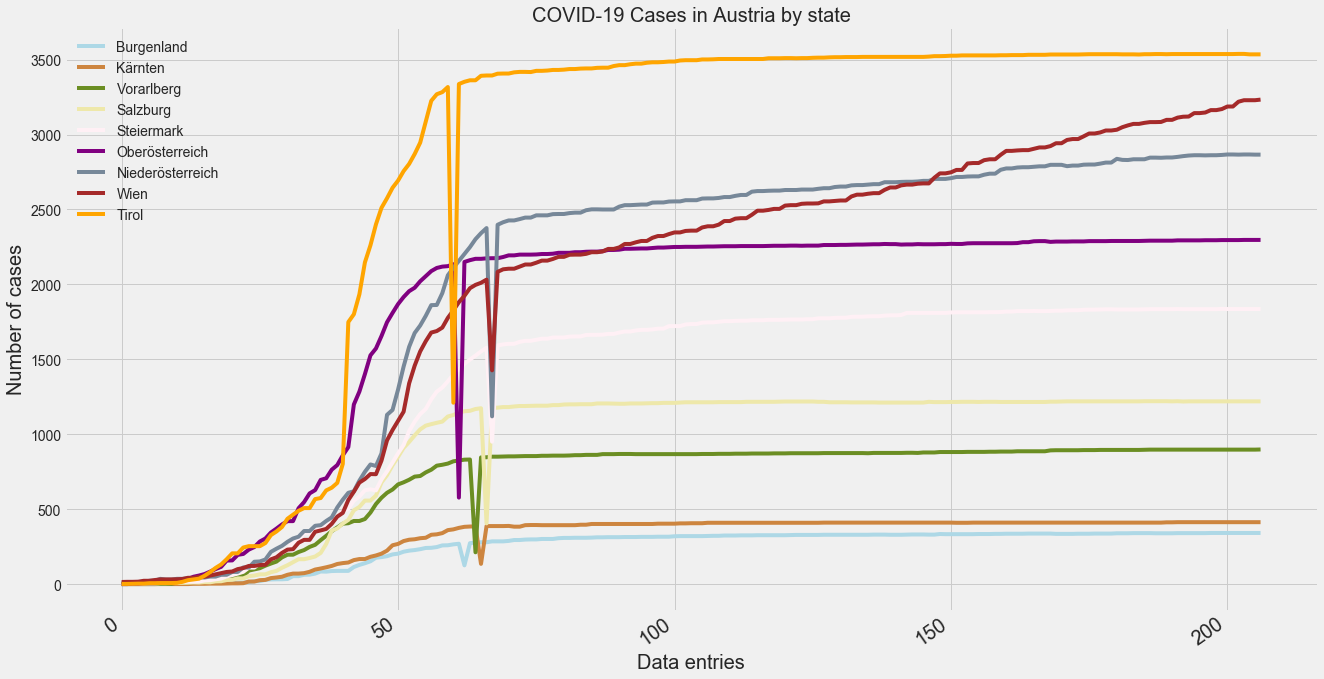

In [34]:
import bokeh
import random
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(20,10))
line_1 = cases_b[0:smallest_number]
line_2 = cases_k[0:smallest_number]
line_3 = cases_v[0:smallest_number]
line_4 = cases_s[0:smallest_number]
line_5 = cases_st[0:smallest_number]
line_6 = cases_o[0:smallest_number]
line_7 = cases_n[0:smallest_number]
line_8 = cases_w[0:smallest_number]
line_9 = cases_t[0:smallest_number]

n = len(line_1)
scale = 'linear'
fontsize = 20
y_pos = date_b[0:smallest_number]

ax.set_xticklabels(y_pos, rotation=35, horizontalalignment= 'right', fontsize=20)

all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)
c = random.choices(all_colors, k=n)

ax.plot(y_pos,line_1,color=c[1], label='Burgenland')
ax.plot(y_pos,line_2,color=c[2], label='Kärnten')
ax.plot(y_pos,line_3,color=c[3], label='Vorarlberg')
ax.plot(y_pos,line_4,color=c[4], label='Salzburg')
ax.plot(y_pos,line_5,color=c[5], label='Steiermark')
ax.plot(y_pos,line_6,color=c[6], label='Oberösterreich')
ax.plot(y_pos,line_7,color=c[7], label='Niederösterreich')
ax.plot(y_pos,line_8,color=c[8], label='Wien')
ax.plot(y_pos,line_9,color="orange", label='Tirol')

ax.legend(loc = 'upper left')     
ax.set_xscale(scale)

ax.set_title(f'COVID-19 Cases in Austria by state', fontsize=20)
ax.set_xlabel(f'Data entries', fontsize=20)
ax.set_ylabel(f'Number of cases', fontsize=20)

plt.savefig('images/time_cases_state.png', dpi=400, format='png')

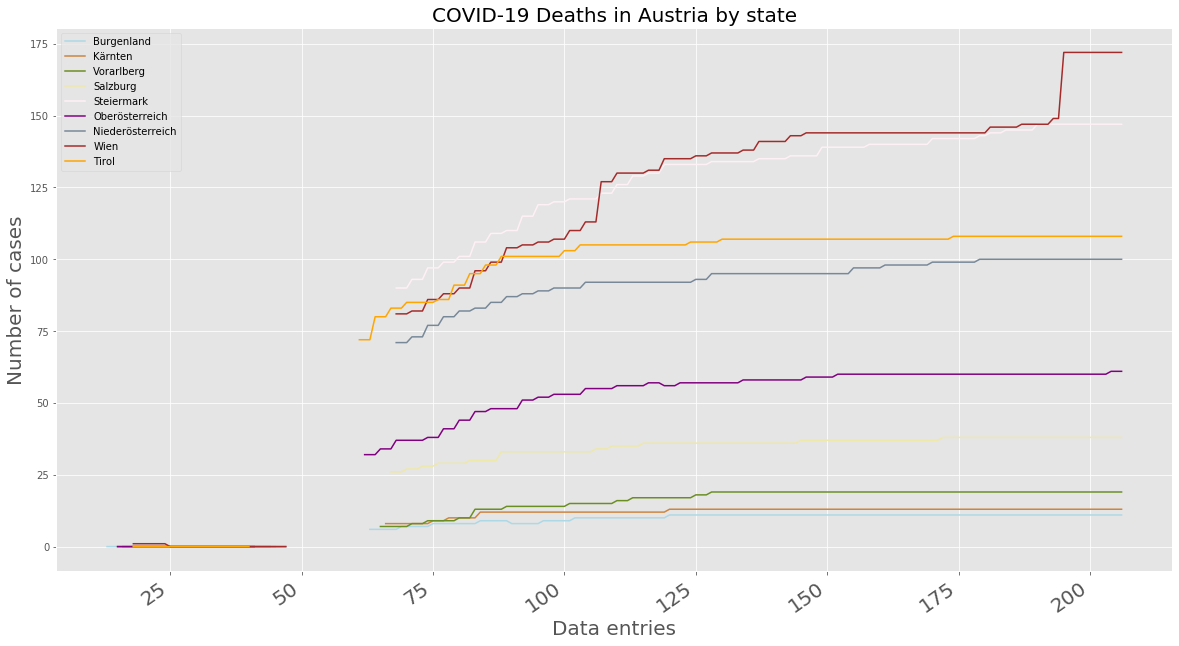

In [32]:
import bokeh
import random
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(20,10))
line_1 = deaths_b[0:smallest_number]
line_2 = deaths_k[0:smallest_number]
line_3 = deaths_v[0:smallest_number]
line_4 = deaths_s[0:smallest_number]
line_5 = deaths_st[0:smallest_number]
line_6 = deaths_o[0:smallest_number]
line_7 = deaths_n[0:smallest_number]
line_8 = deaths_w[0:smallest_number]
line_9 = deaths_t[0:smallest_number]

n = len(line_1)
scale = 'linear'
fontsize = 20
y_pos = date_b[0:smallest_number]

ax.set_xticklabels(y_pos, rotation=35, horizontalalignment= 'right', fontsize=20)

all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)
c = random.choices(all_colors, k=n)

ax.plot(y_pos,line_1,color=c[1], label='Burgenland')
ax.plot(y_pos,line_2,color=c[2], label='Kärnten')
ax.plot(y_pos,line_3,color=c[3], label='Vorarlberg')
ax.plot(y_pos,line_4,color=c[4], label='Salzburg')
ax.plot(y_pos,line_5,color=c[5], label='Steiermark')
ax.plot(y_pos,line_6,color=c[6], label='Oberösterreich')
ax.plot(y_pos,line_7,color=c[7], label='Niederösterreich')
ax.plot(y_pos,line_8,color=c[8], label='Wien')
ax.plot(y_pos,line_9,color="orange", label='Tirol')

ax.legend(loc = 'upper left')     
ax.set_xscale(scale)

ax.set_title(f'COVID-19 Deaths in Austria by state', fontsize=20)
ax.set_xlabel(f'Data entries', fontsize=20)
ax.set_ylabel(f'Number of cases', fontsize=20)

plt.savefig('images/time_deaths_state.png', dpi=400, format='png')

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def update_line(num, data, line):
    line.set_data(data[..., :num])
    return line,

## GIF failed attempt

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


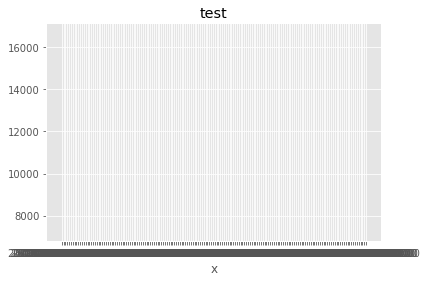

In [29]:
fig1 = plt.figure()

# Fixing random state for reproducibility
np.random.seed(19680801)

data = np.random.rand(2, 25)
l, = plt.plot(date_global,cases_global,color='navy', label='Confirmed cases')

plt.xlabel('x')
plt.title('test')
line_ani = animation.FuncAnimation(fig1, update_line, 25, fargs=(data, l),
                                   interval=50, blit=True)
line_ani.save('lines.gif')

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


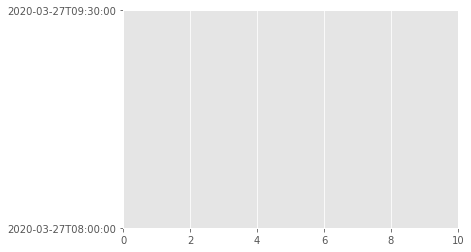

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

x = cases_global
y = date_global

fig, ax = plt.subplots()
line, = ax.plot(x, y, color='k')

def update(num, x, y, line):
    line.set_data(x[:num], y[:num])
    line.axes.axis([0, 10, 0, 1])
    return line,

ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, y, line],
                              interval=25, blit=True)
ani.save('test.gif')
plt.show()